In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [6]:
import torch
import transformers
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict

In [7]:
# 1. 데이터셋 다운로드
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="datas/ratings_train.txt")
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="datas/ratings_test.txt")

In [8]:
#모델 및 토크나이저 로드
checkpoint = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
train_data = pd.read_table('datas/ratings_train.txt')
test_data = pd.read_table('datas/ratings_test.txt')

In [10]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [11]:
#중복제거
train_data.drop_duplicates(subset=['document'], inplace=True)

<Axes: xlabel='label'>

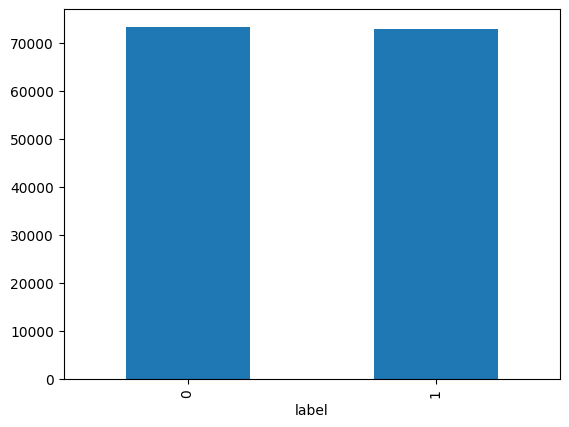

In [12]:
#label비중 확인
train_data['label'].value_counts().plot(kind='bar')

In [13]:
#null제거
train_data = train_data.dropna(how='any')

In [14]:
#테스트 데이터 null 제거
test_data = test_data.dropna(how='any')

In [15]:
#Dataset만들기1
validation_data, test_data  = train_test_split(test_data, test_size=0.7, random_state=42)
datasets = DatasetDict({"train": Dataset.from_pandas(train_data),"validation": Dataset.from_pandas(validation_data),"test": Dataset.from_pandas(test_data)})

In [16]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 146182
    })
    validation: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 14999
    })
    test: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__'],
        num_rows: 34998
    })
})

In [17]:
def tokenize_function(example):
    return tokenizer(example["document"], truncation=True)

In [18]:
tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/146182 [00:00<?, ? examples/s]

Map:   0%|          | 0/14999 [00:00<?, ? examples/s]

Map:   0%|          | 0/34998 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 146182
    })
    validation: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14999
    })
    test: Dataset({
        features: ['id', 'document', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 34998
    })
})

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["id", 'document', "__index_level_0__"]}
[len(x) for x in samples["input_ids"]]

[13, 25, 3, 17, 36, 29, 14, 61]

In [21]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 61]),
 'token_type_ids': torch.Size([8, 61]),
 'attention_mask': torch.Size([8, 61]),
 'labels': torch.Size([8])}

In [22]:
training_args = TrainingArguments("test-trainer")

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [25]:
trainer.train()

Step,Training Loss
500,0.439100
1000,0.416100
1500,0.402100
2000,0.390800
2500,0.388100
3000,0.370600
3500,0.381000
4000,0.368500
4500,0.372500
5000,0.365800


Checkpoint destination directory test-trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-3500 already exists and is non-empty. Saving will 

TrainOutput(global_step=54819, training_loss=0.33835752699388594, metrics={'train_runtime': 3664.9647, 'train_samples_per_second': 119.659, 'train_steps_per_second': 14.958, 'total_flos': 1.172309704374804e+16, 'train_loss': 0.33835752699388594, 'epoch': 3.0})

In [26]:
trainer.save_model('models/models0506_klue/')

In [27]:
predictions = trainer.predict(tokenized_datasets['validation'])
print(predictions)

PredictionOutput(predictions=array([[ 2.1182113, -2.070733 ],
       [ 1.5139875, -1.4081607],
       [ 1.6375772, -1.752878 ],
       ...,
       [-1.8543115,  1.8029877],
       [-1.7909642,  1.7481558],
       [-2.5580273,  2.872008 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.4077167510986328, 'test_runtime': 25.9791, 'test_samples_per_second': 577.348, 'test_steps_per_second': 72.173})


In [28]:
preds = np.argmax(predictions.predictions, axis=-1)

In [29]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

/tmp/ipykernel_15302/3131256073.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:753: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'accuracy': 0.8877925195013001, 'f1': 0.8911595421328332}